In [1]:
import os

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import argparse
import joblib
import tensorflow as tf
import math
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


2023-08-17 11:05:21.552041: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-17 11:05:21.578532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 11:05:22.057584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# HIDDEN FUNCTION

## Utils

In [2]:
import os
import numpy as np
import tensorflow as tf

#---------------------------------------------------------------------------------------------------------------------
# CREATE TRAIN-TEST SPLIT (80:20)
#---------------------------------------------------------------------------------------------------------------------
def np_array_convert(dataset, prev, pred):
    dataX, dataY = [], []

    for col_index in range( len(dataset.columns) ):
        col = dataset[dataset.columns[col_index]]
        
        for i in range(len(dataset) - prev - pred + 1):
            a = col.iloc[i:(i+prev)]
            dataX.append(a)
            dataY.append(col.iloc[i + prev: i + prev + pred])

    return (np.array(dataX), np.array(dataY))


#-----------------------------------------------------------
# USING A LSTM MODEL FOR PREDICTION ON TIME SERIES
#-----------------------------------------------------------
def model_setup(x_train_scale, pred_day):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(512,input_shape=(x_train_scale.shape[1], 1),return_sequences=True))
    model.add(tf.keras.layers.LSTM(512,return_sequences=False))
    model.add(tf.keras.layers.Dense(pred_day))

    # model.summary()

    model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

    return model


#-----------------------------------------------------------
# DEFINING CALLBACKS
#-----------------------------------------------------------
def callback_setup():
    es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
    lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)


    checkpoint_path = "./checkpoint/cp"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        save_freq=999999)
    
    return [es , lr_red, cp_callback]

## eval

In [3]:
def read_data(filename):
    df = pd.read_csv(filename)
    df = df.set_index('timestamp')
    return df


#------------------------------------------------------------------------------------
# Transform DataFrame into format expected by model for evaluation
#------------------------------------------------------------------------------------

def transform_data(df, prev_day, pred_day, scaler_path):

    # Chunk datafram into Features (number of days that model needs to know) and Labels (number of days model can predict)
    x_test, y_test = np_array_convert(df, prev = prev_day, pred = pred_day)


    # Normalize the data using the saved the parameters of normalization
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler = joblib.load(scaler_path + '/scaler_features.pkl')
    x_test_scale = scaler.transform(pd.DataFrame(x_test))

    scaler = joblib.load(scaler_path + '/scaler_labels.pkl')
    y_test_scale = scaler.transform(pd.DataFrame(y_test))

    return x_test, y_test, x_test_scale, y_test_scale

#------------------------------------------------------------------------------------
# Print the test results
#------------------------------------------------------------------------------------

def test_score(preds, y_test, pred_day):

    # mean_squared_error
    testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
    print('Test Score: %.2f RMSE' % (testScore_1))

    # mean_absolute_error
    testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
    print('Test Score: %f MAE' % (testScore_2))

    # MAPE
    testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
    print('Test Score: %f MAPE' % (testScore_3))


    # mean absolute mean error
    arr = 1 - abs(y_test[:] - preds[:])/y_test[:]
    arr = arr = np.where(arr < 0, 0, arr)
    acc = sum(sum(arr)/len(y_test))/pred_day

    print("*** Accuracy: ", acc * 100)

# VARIABLES

In [4]:
eval_path = "../data/preprocess_data/cpu/test.csv"

model_path = "../model/cpu/12H"
scaler_path = model_path + "/scaler"
prev_day = 12
pred_day = 2

<Axes: xlabel='timestamp'>

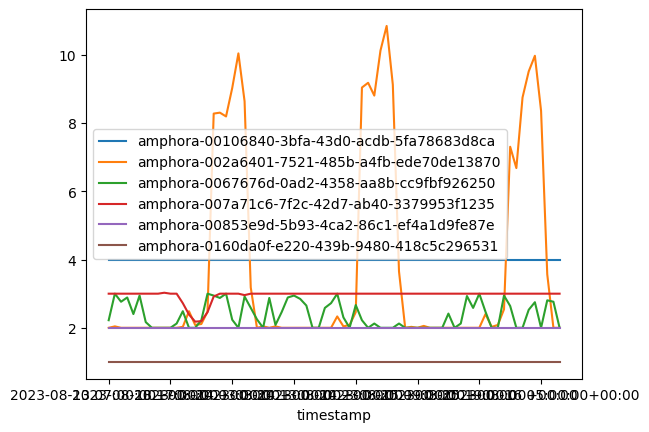

In [5]:
df = pd.read_csv(eval_path)
df = df.set_index('timestamp')
df.plot()

# Visualization

In [6]:
x_test, y_test, x_test_scale, y_test_scale = transform_data(df, prev_day, pred_day, scaler_path)

model = model_setup(x_test_scale, pred_day)
model = tf.keras.models.load_model(model_path)

preds = model.predict(x_test_scale)
scaler = joblib.load(scaler_path + '/scaler_labels.pkl')
preds = scaler.inverse_transform(preds)

test_score(preds, y_test, pred_day)

2023-08-17 11:05:23.109091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 11:05:23.122893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 11:05:23.123019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

12/12 [==============================] - 0s 1ms/step
Test Score: 1.49 RMSE
Test Score: 0.784436 MAE
Test Score: 18.688247 MAPE
*** Accuracy:  84.63566874402655


2023-08-17 11:05:25.064592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-17 11:05:25.087638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
s = pd.Series(df.index[prev_day+pred_day:])
df.columns

Index(['amphora-00106840-3bfa-43d0-acdb-5fa78683d8ca',
       'amphora-002a6401-7521-485b-a4fb-ede70de13870',
       'amphora-0067676d-0ad2-4358-aa8b-cc9fbf926250',
       'amphora-007a71c6-7f2c-42d7-ab40-3379953f1235',
       'amphora-00853e9d-5b93-4ca2-86c1-ef4a1d9fe87e',
       'amphora-0160da0f-e220-439b-9480-418c5c296531'],
      dtype='object')

In [8]:
test0 = pd.DataFrame(df[ df.columns[0] ])
test1 = pd.DataFrame(df[ df.columns[1] ])
test2 = pd.DataFrame(df[ df.columns[2] ])
test3 = pd.DataFrame(df[ df.columns[3] ])
test4 = pd.DataFrame(df[ df.columns[4] ])

In [9]:
def eval_each_type(test_type, prev_day, pred_day, scaler_path, model):
    x_test, y_test, x_test_scale, y_test_scale = transform_data(test_type, prev_day, pred_day, scaler_path)
    # print(y_test)

    scaler = joblib.load(scaler_path + '/scaler_labels.pkl')
    preds = model.predict(x_test_scale)
    preds = scaler.inverse_transform(preds)

    plt.rcParams["figure.figsize"] = (32,12)

    TestY= pd.DataFrame(y_test,columns=[str(i) for i in range(pred_day)])
    PredY= pd.DataFrame(preds, columns=[str(i) for i in range(pred_day)])

    print(PredY)

    plot_max = plt.figure(6)
    plt.plot(TestY['0'])
    plt.plot(PredY['0'])

    plt.show()

2/2 [==============================] - 0s 2ms/step
           0         1
0   3.719082  4.149227
1   3.719082  4.149227
2   3.719082  4.149227
3   3.719082  4.149227
4   3.719082  4.149227
..       ...       ...
56  3.719082  4.149227
57  3.719082  4.149227
58  3.719082  4.149227
59  3.719082  4.149227
60  3.719082  4.149227

[61 rows x 2 columns]


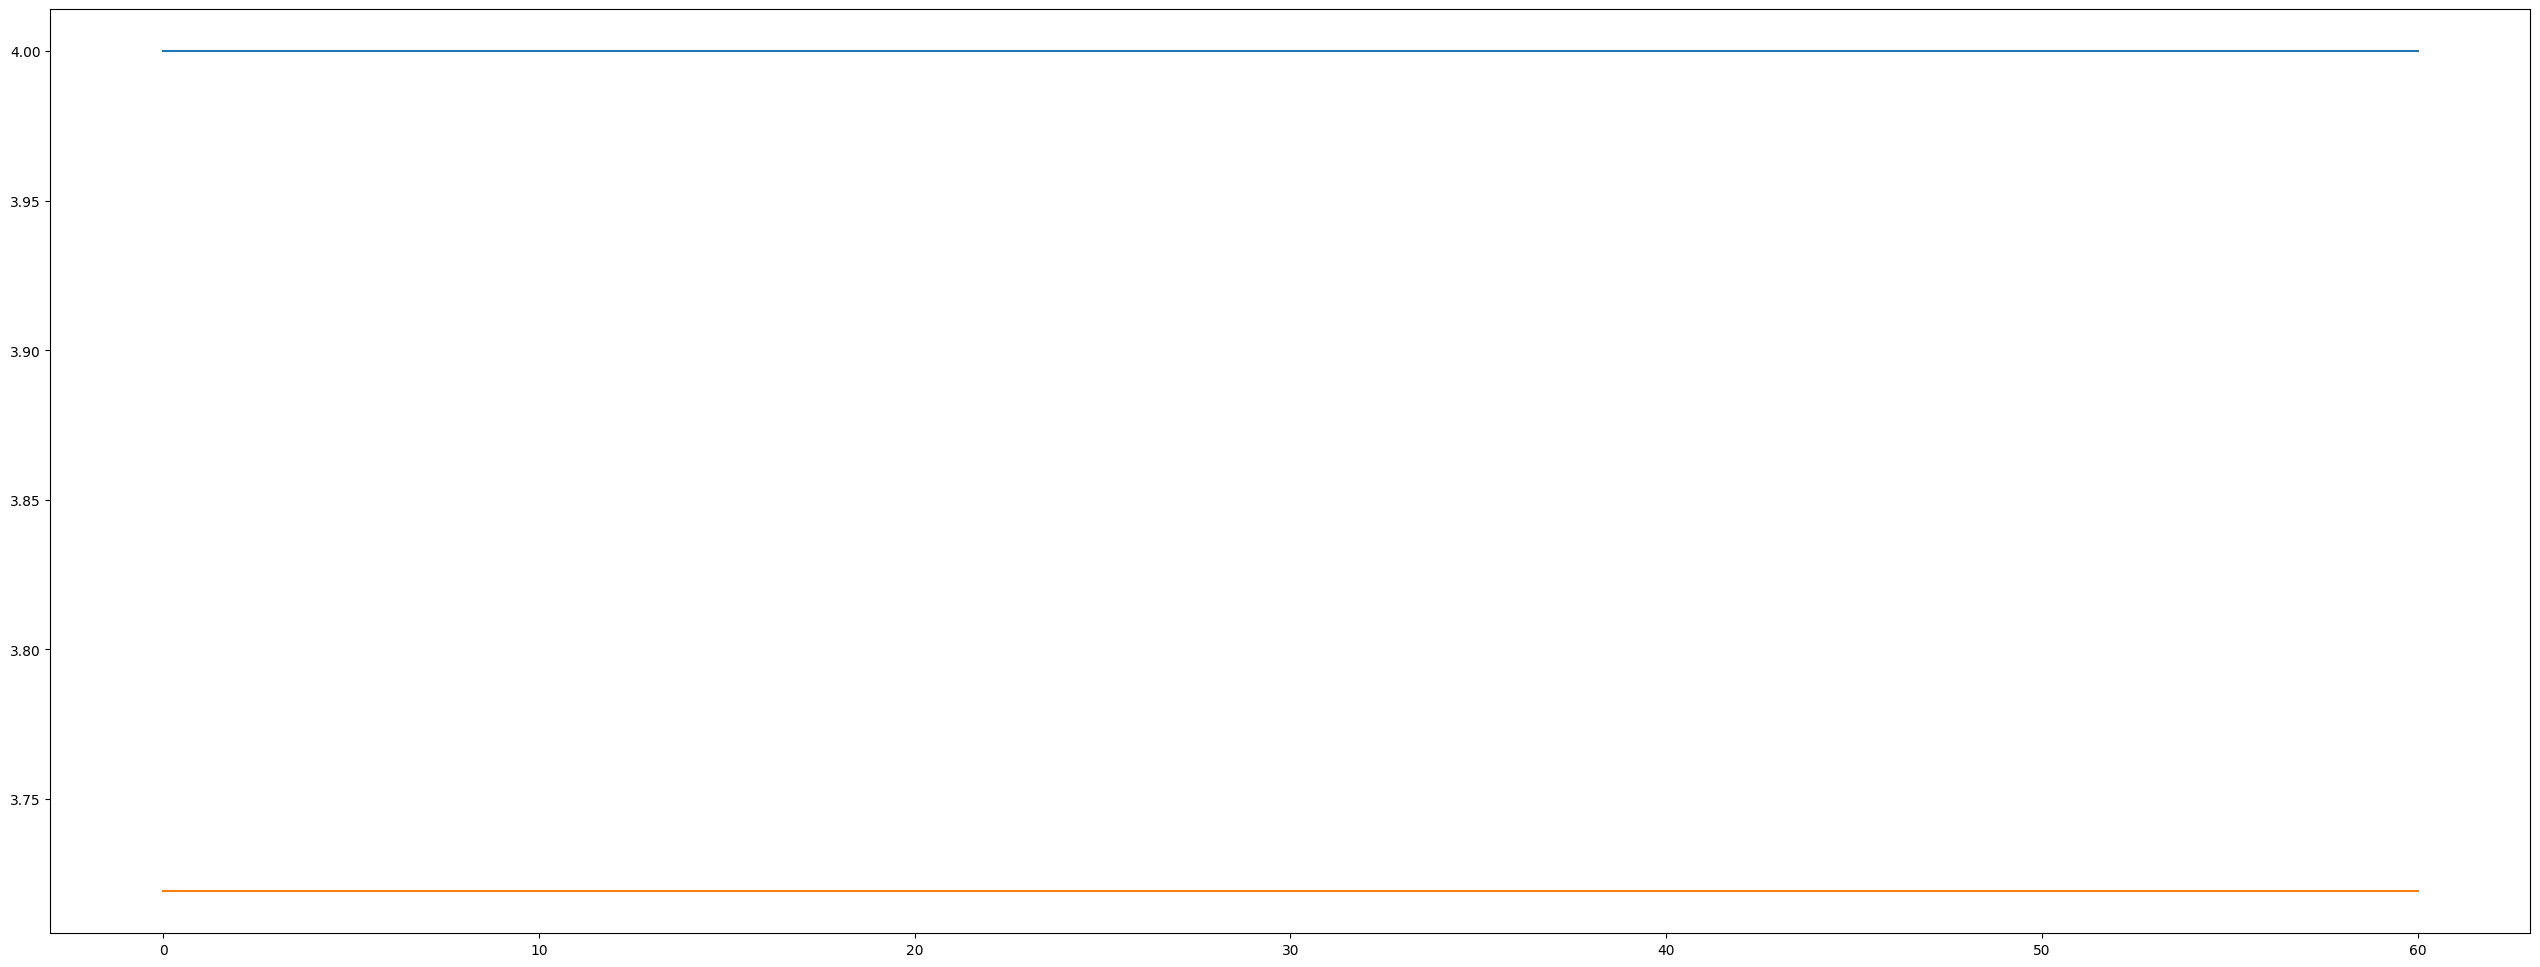

2/2 [==============================] - 0s 2ms/step
           0         1
0   1.985150  2.140110
1   1.986802  2.141792
2   2.021313  2.177657
3   2.046184  2.204689
4   2.064283  2.225170
..       ...       ...
56  3.699985  3.975374
57  4.486139  4.834968
58  5.273782  5.709791
59  5.876954  6.404318
60  6.005850  6.611303

[61 rows x 2 columns]


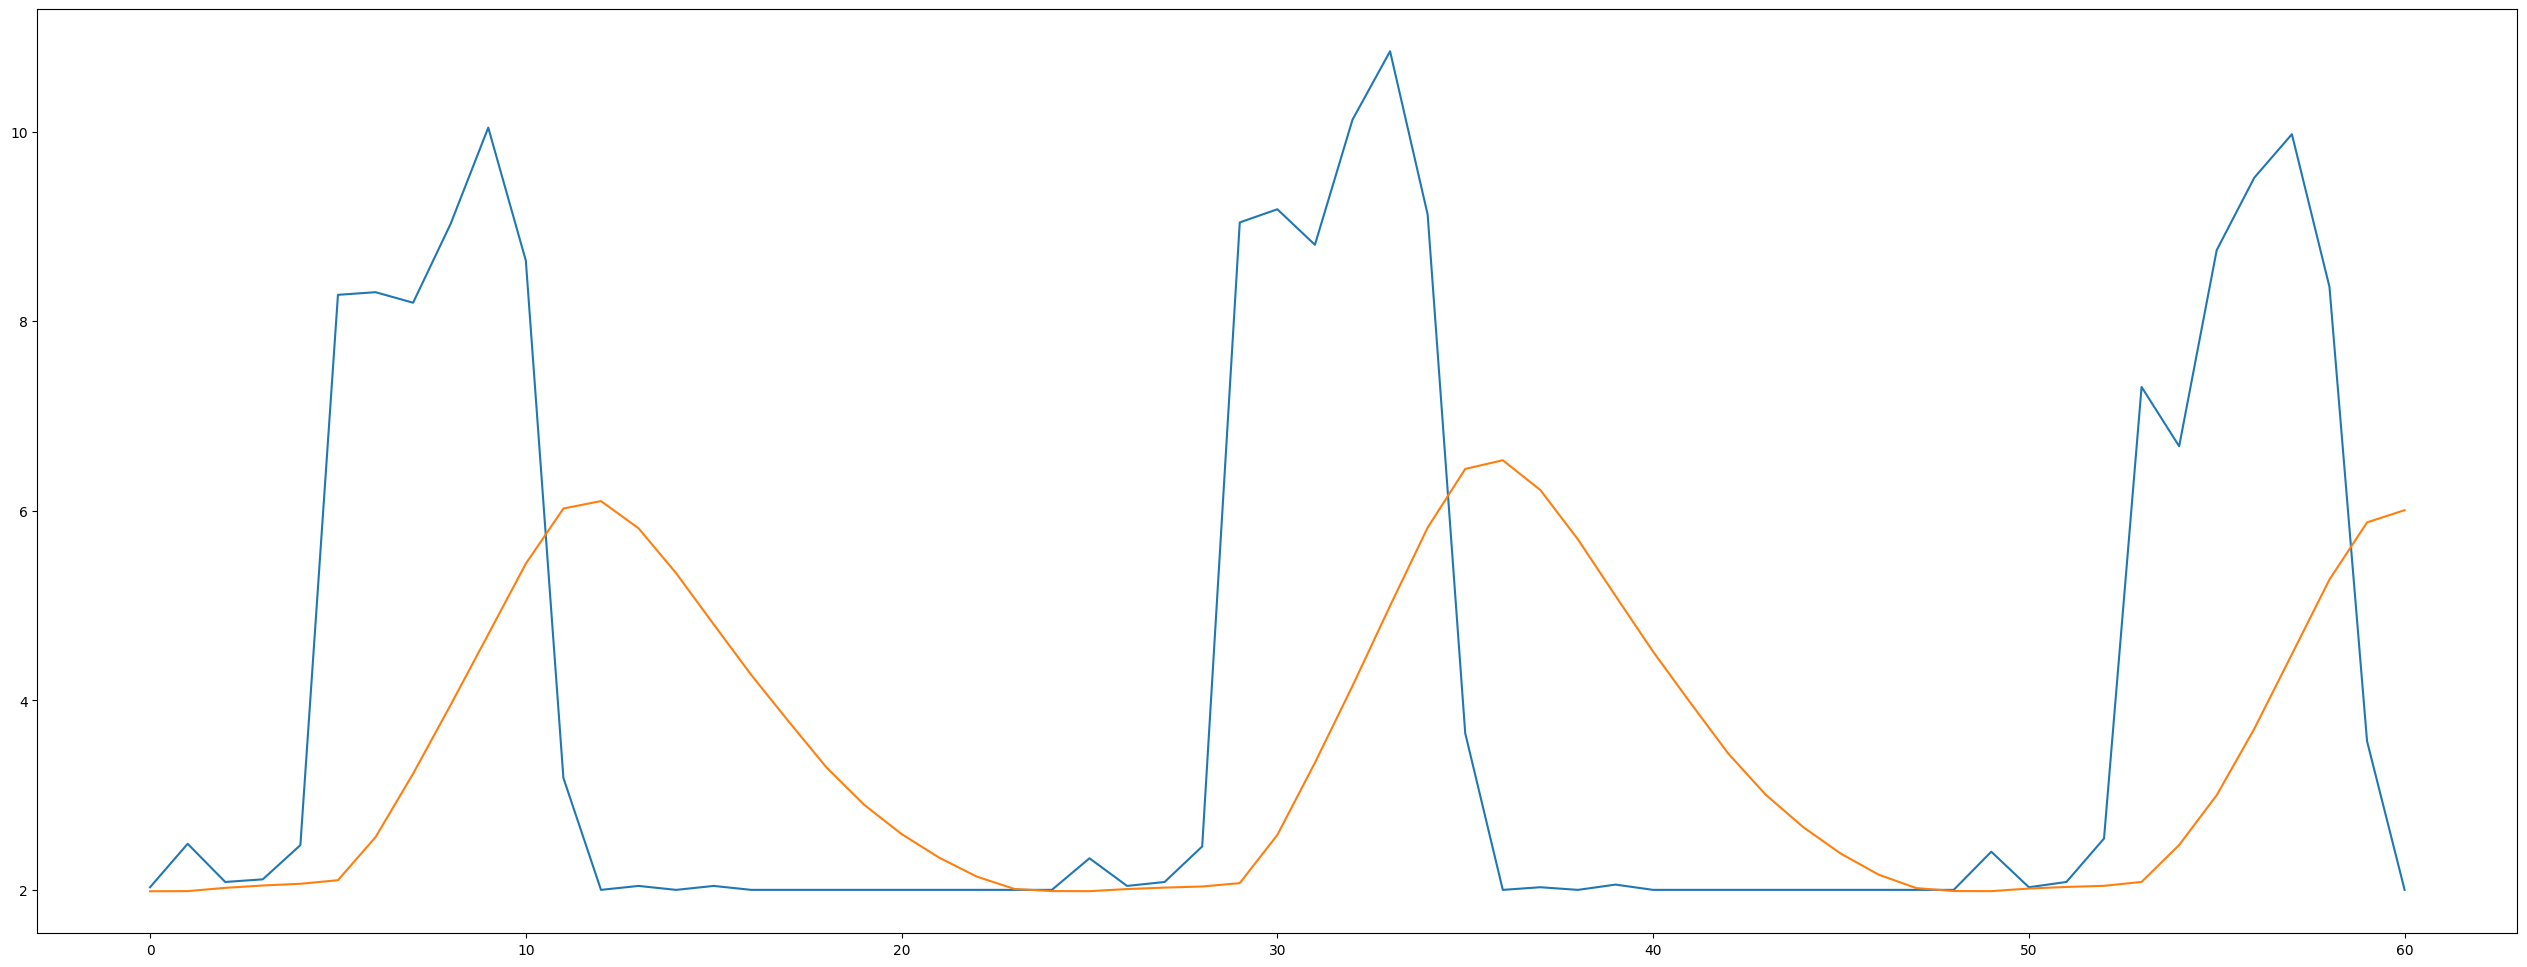

2/2 [==============================] - 0s 2ms/step
           0         1
0   2.206788  2.421735
1   2.192381  2.402665
2   2.159196  2.357749
3   2.127798  2.317375
4   2.110866  2.291596
..       ...       ...
56  2.339722  2.557646
57  2.326767  2.546345
58  2.344171  2.564984
59  2.317903  2.531681
60  2.335833  2.547801

[61 rows x 2 columns]


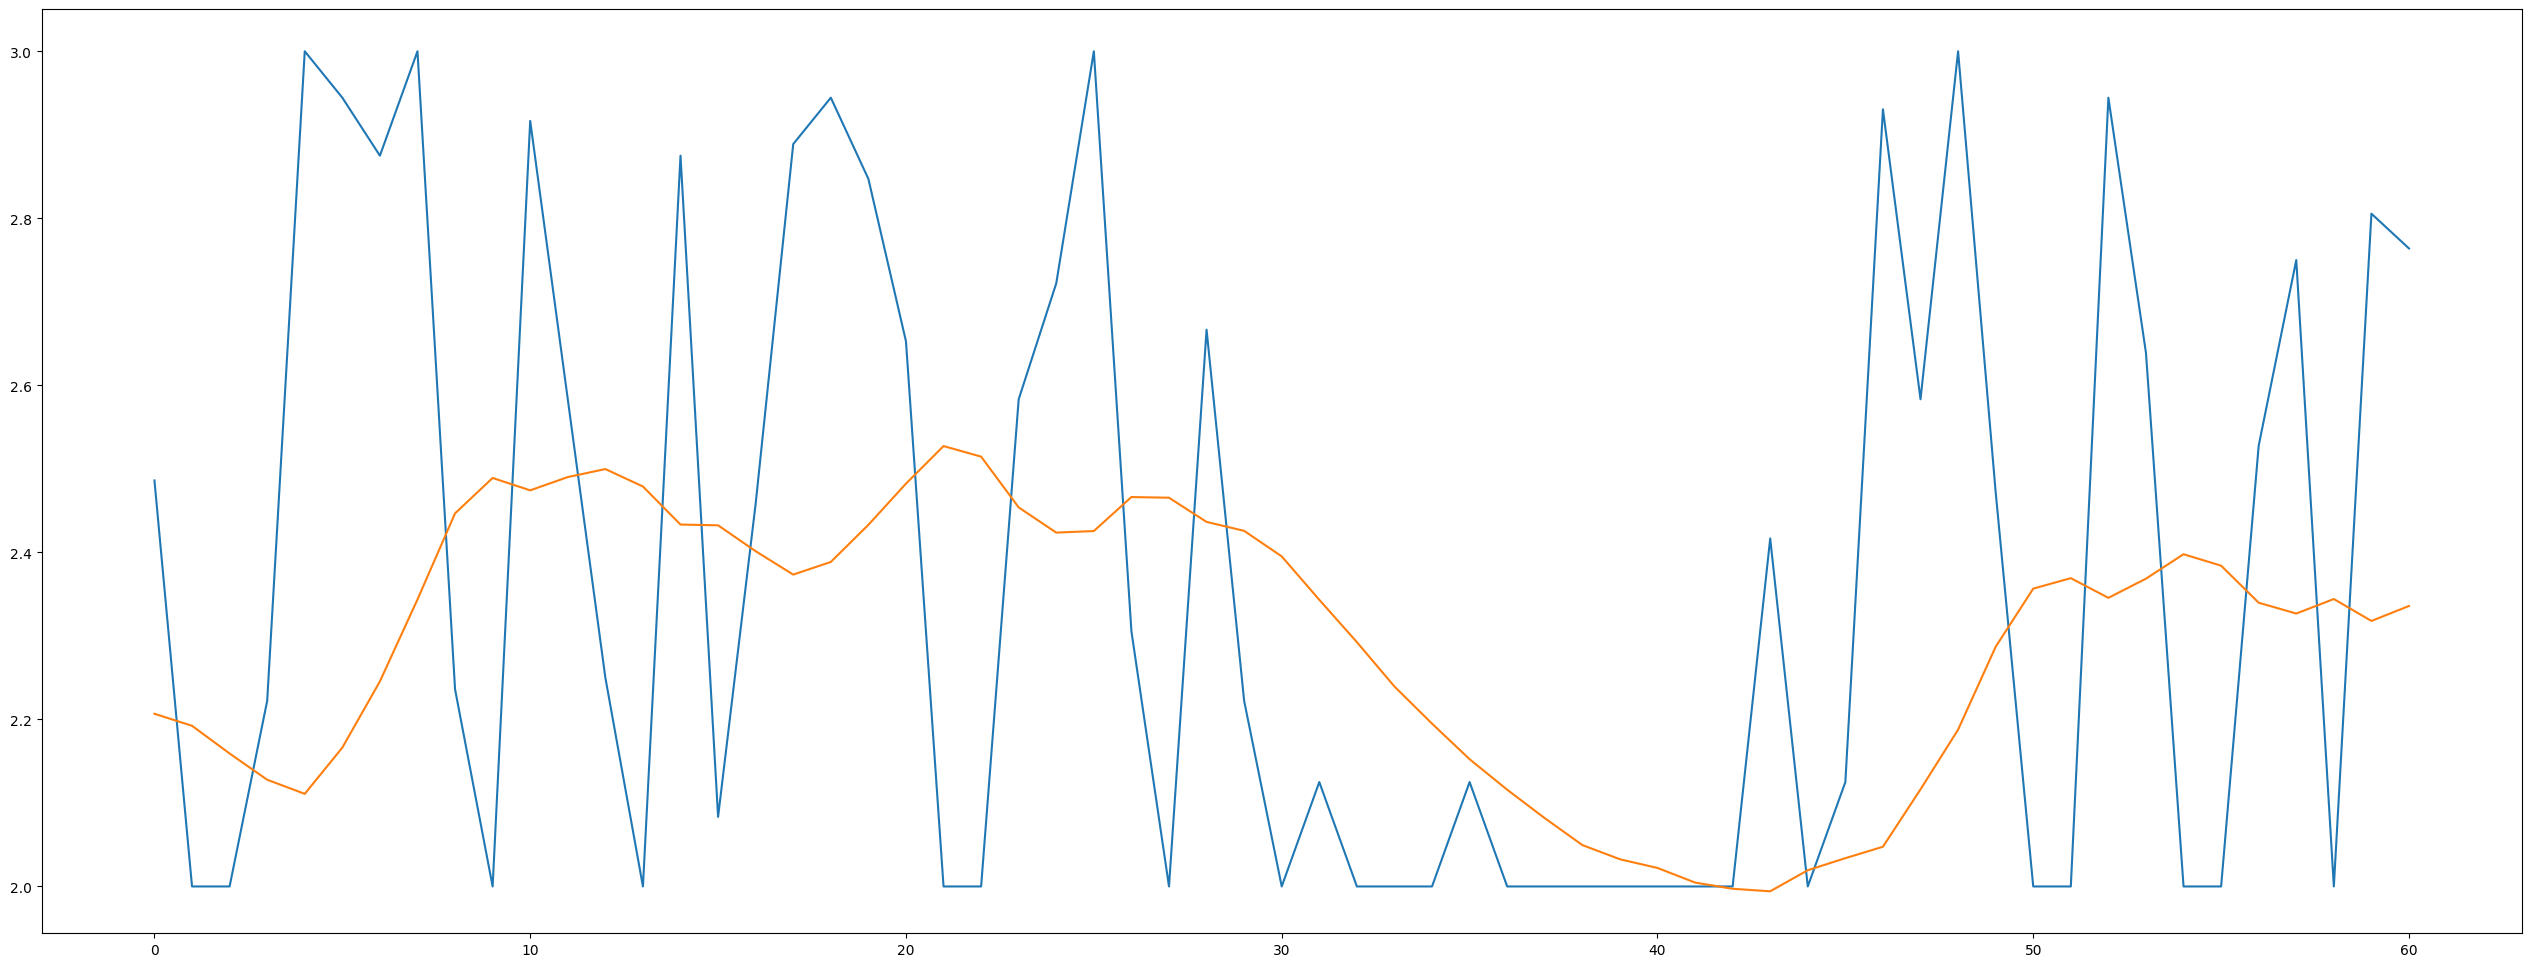

2/2 [==============================] - 0s 2ms/step
           0         1
0   2.872381  3.169055
1   2.852977  3.148825
2   2.799887  3.092828
3   2.715950  3.003195
4   2.621052  2.900101
..       ...       ...
56  2.869050  3.165456
57  2.869050  3.165456
58  2.869050  3.165456
59  2.869050  3.165456
60  2.869050  3.165456

[61 rows x 2 columns]


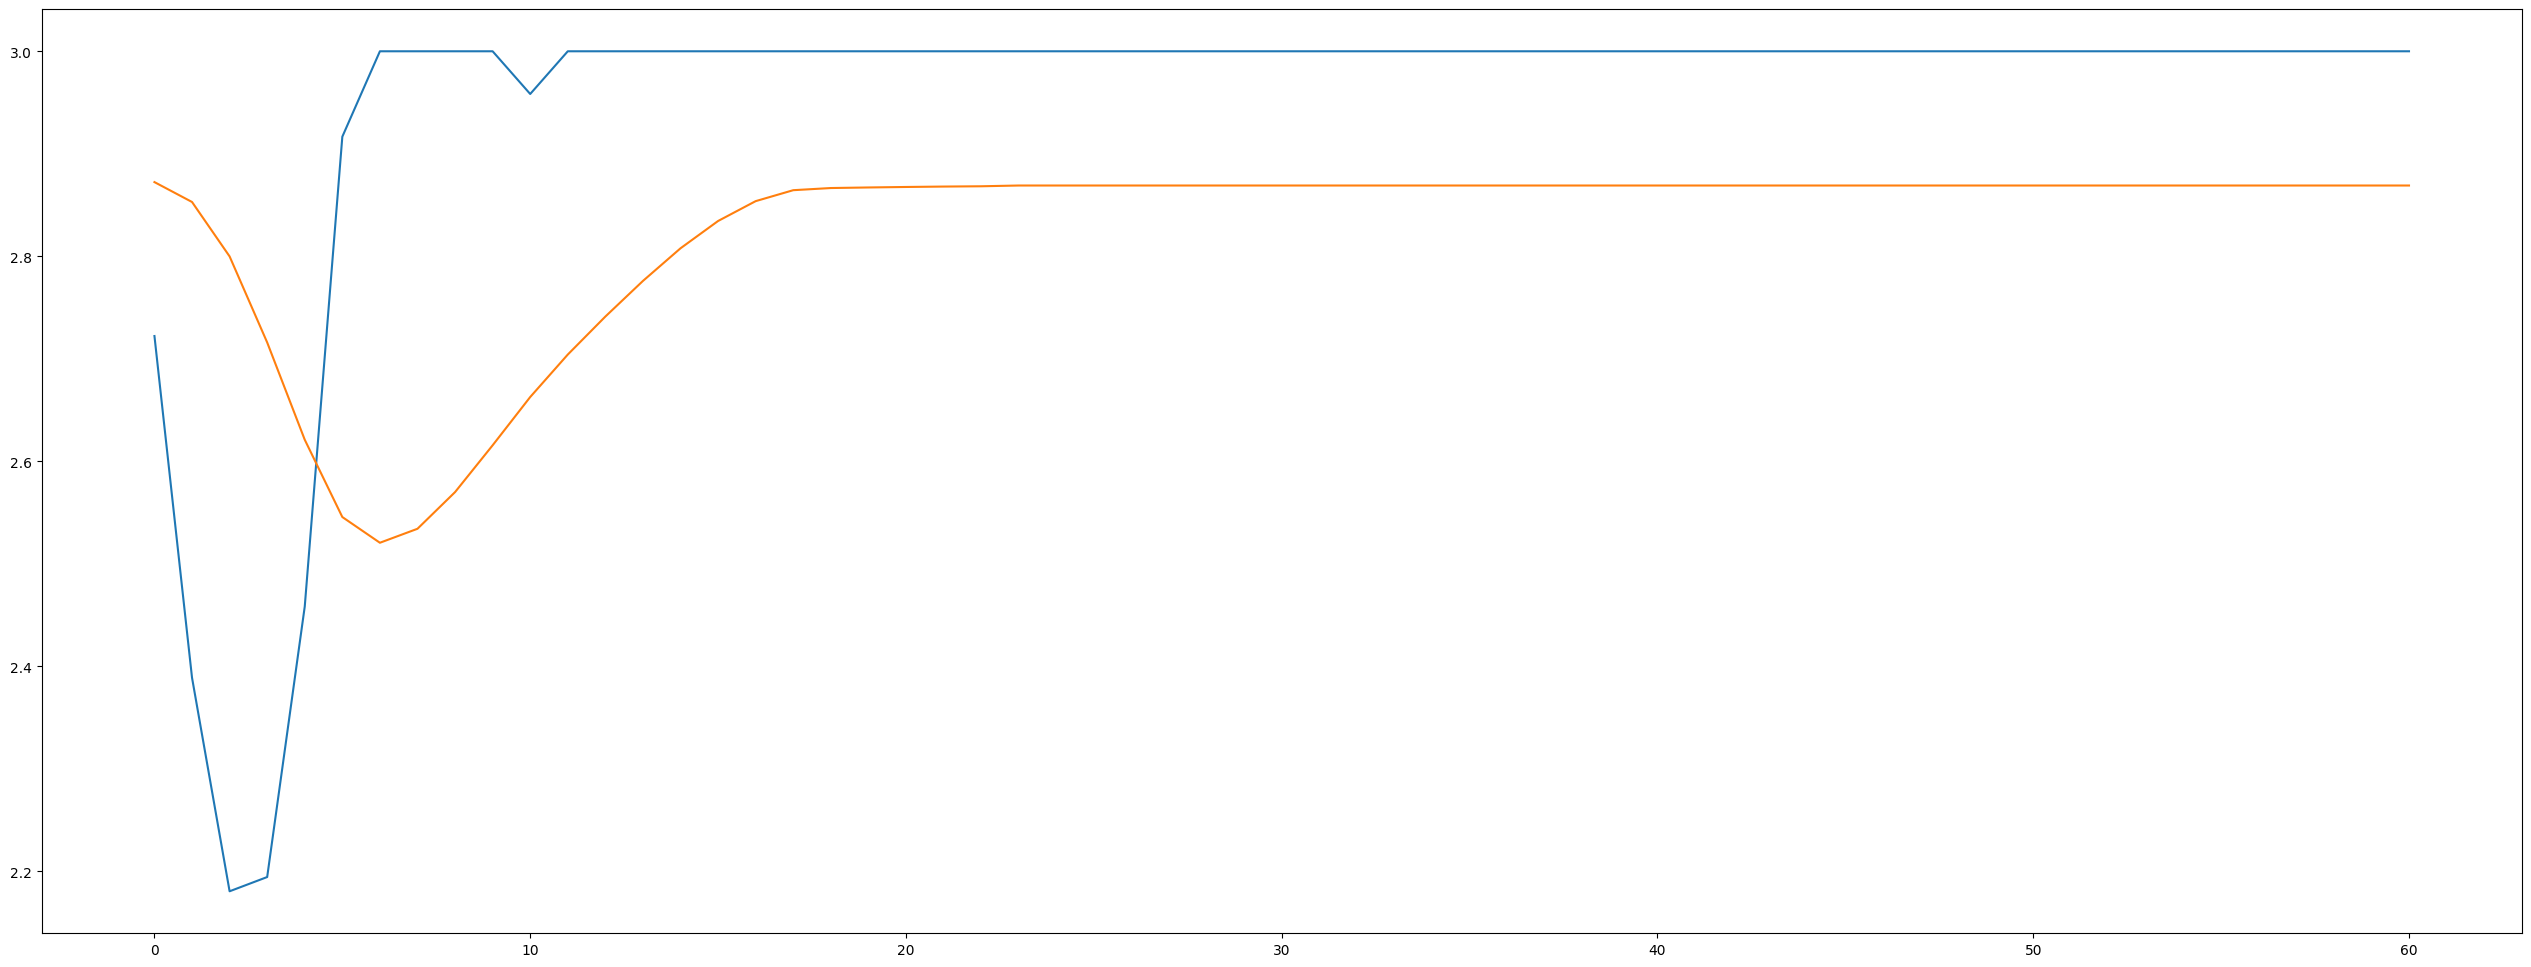

In [10]:
x_test, y_test, x_test_scale, y_test_scale = transform_data(test0, prev_day, pred_day, scaler_path)
model = model_setup(x_test_scale, pred_day)
model = tf.keras.models.load_model(model_path)

eval_each_type(test0, prev_day, pred_day, scaler_path, model)
eval_each_type(test1, prev_day, pred_day, scaler_path, model)
eval_each_type(test2, prev_day, pred_day, scaler_path, model)
eval_each_type(test3, prev_day, pred_day, scaler_path, model)

In [11]:
df1 = pd.read_csv(eval_path).tail(prev_day + pred_day)
df1

,timestamp,amphora-00106840-3bfa-43d0-acdb-5fa78683d8ca,amphora-002a6401-7521-485b-a4fb-ede70de13870,amphora-0067676d-0ad2-4358-aa8b-cc9fbf926250,amphora-007a71c6-7f2c-42d7-ab40-3379953f1235,amphora-00853e9d-5b93-4ca2-86c1-ef4a1d9fe87e,amphora-0160da0f-e220-439b-9480-418c5c296531
60,2023-08-15 19:00:00+00:00,4.0,2.000000,3.000000,3.0,2.0,1.0
61,2023-08-15 20:00:00+00:00,4.0,2.402778,2.472222,3.0,2.0,1.0
62,2023-08-15 21:00:00+00:00,4.0,2.027778,2.000000,3.0,2.0,1.0
63,2023-08-15 22:00:00+00:00,4.0,2.083333,2.000000,3.0,2.0,1.0
64,2023-08-15 23:00:00+00:00,4.0,2.541667,2.944444,3.0,2.0,1.0
65,2023-08-16 00:00:00+00:00,4.0,7.305556,2.638889,3.0,2.0,1.0
66,2023-08-16 01:00:00+00:00,4.0,6.680556,2.000000,3.0,2.0,1.0
67,2023-08-16 02:00:00+00:00,4.0,8.750000,2.000000,3.0,2.0,1.0
68,2023-08-16 03:00:00+00:00,4.0,9.513889,2.527778,3.0,2.0,1.0
69,2023-08-16 04:00:00+00:00,4.0,9.972222,2.750000,3.0,2.0,1.0


# One prediction comparison

In [12]:
df1 = pd.read_csv(eval_path).tail(prev_day + pred_day)
df1 = df1.set_index('timestamp')
col = df1.columns

x_test, y_test, x_test_scale, y_test_scale = transform_data(df1, prev_day, pred_day, scaler_path)

model = model_setup(x_test_scale, pred_day)
model = tf.keras.models.load_model(model_path)

preds = model.predict(x_test_scale)
scaler = joblib.load(scaler_path + '/scaler_labels.pkl')
preds = scaler.inverse_transform(preds)

test_score(preds, y_test, pred_day)

1/1 [==============================] - 0s 449ms/step
Test Score: 1.78 RMSE
Test Score: 0.940111 MAE
Test Score: 42.938409 MAPE
*** Accuracy:  76.29972137115575


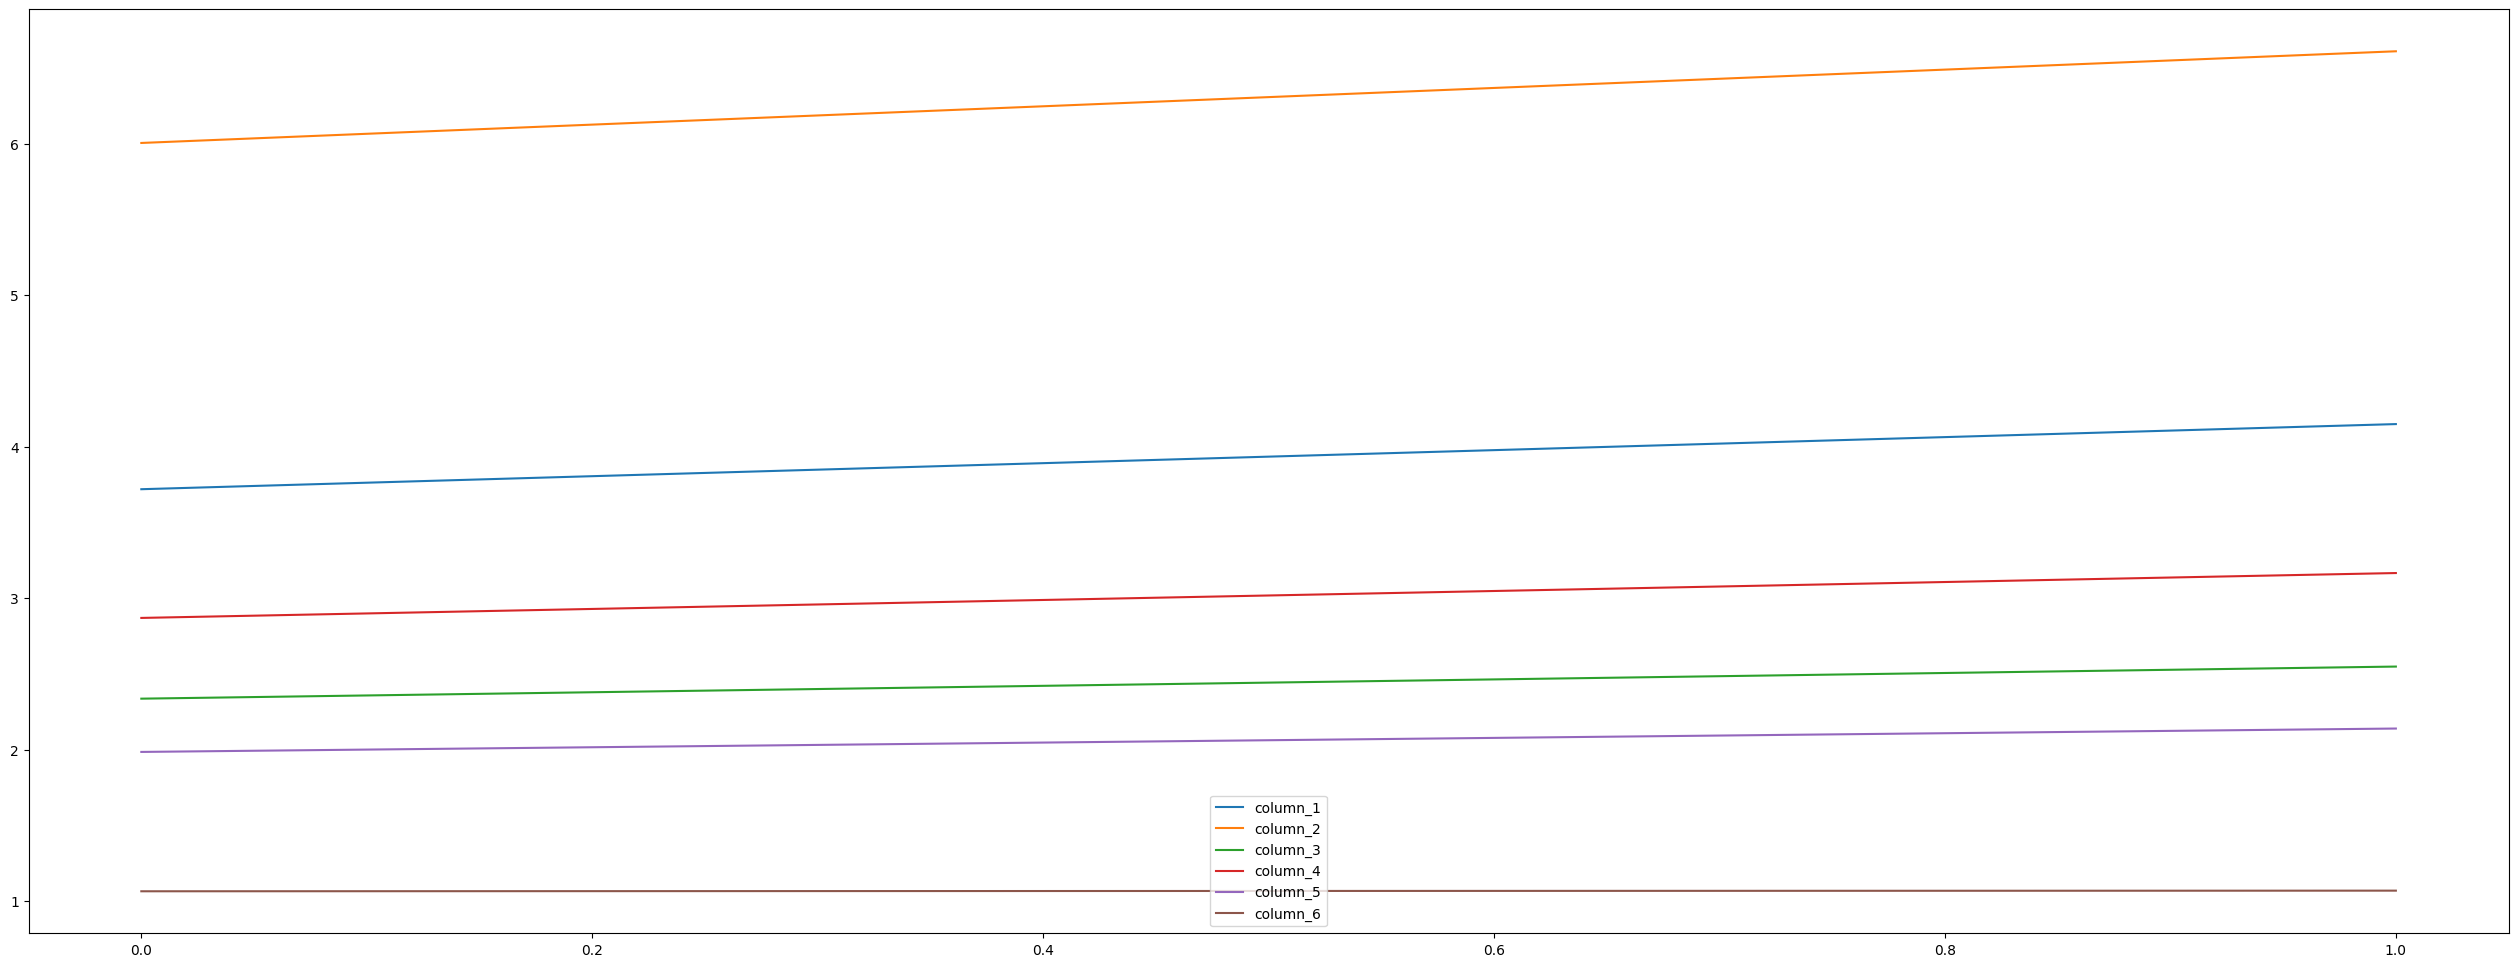

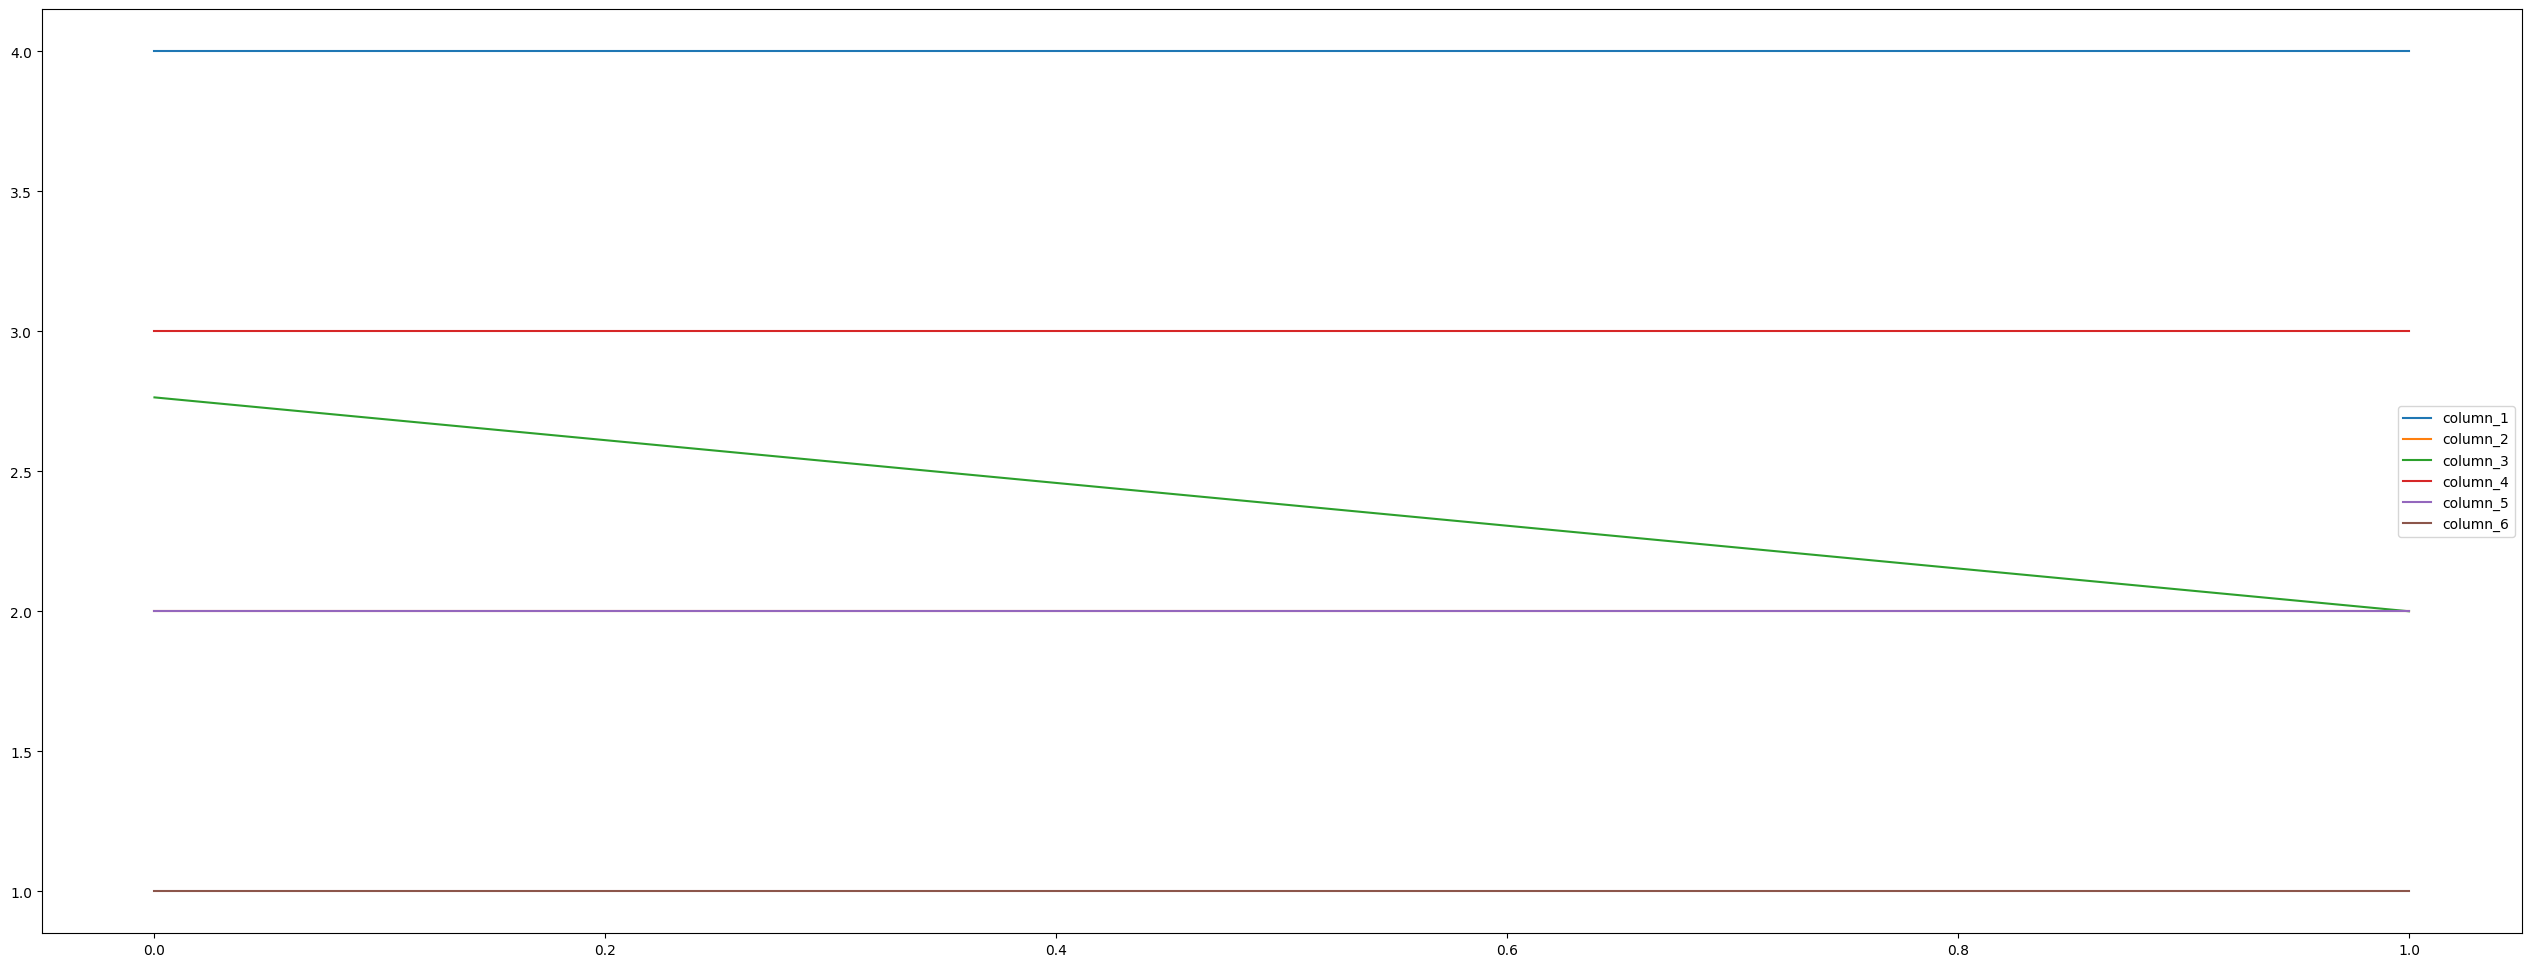

In [13]:

# Create a dictionary where keys are column names and values are sub-arrays
df1 = pd.DataFrame(preds.T, columns=[f"column_{i+1}" for i in range(preds.shape[0])])

# Create a dictionary where keys are column names and values are sub-arrays
df2 = pd.DataFrame(y_test.T, columns=[f"column_{i+1}" for i in range(preds.shape[0])])

df1.plot()
df2.plot()
plt.show()


In [14]:
df1.columns = col
df1

,amphora-00106840-3bfa-43d0-acdb-5fa78683d8ca,amphora-002a6401-7521-485b-a4fb-ede70de13870,amphora-0067676d-0ad2-4358-aa8b-cc9fbf926250,amphora-007a71c6-7f2c-42d7-ab40-3379953f1235,amphora-00853e9d-5b93-4ca2-86c1-ef4a1d9fe87e,amphora-0160da0f-e220-439b-9480-418c5c296531
0,3.719082,6.005849,2.335833,2.869050,1.984069,1.063757
1,4.149227,6.611302,2.547801,3.165456,2.138535,1.067930


In [15]:
df2.columns = col
df2

,amphora-00106840-3bfa-43d0-acdb-5fa78683d8ca,amphora-002a6401-7521-485b-a4fb-ede70de13870,amphora-0067676d-0ad2-4358-aa8b-cc9fbf926250,amphora-007a71c6-7f2c-42d7-ab40-3379953f1235,amphora-00853e9d-5b93-4ca2-86c1-ef4a1d9fe87e,amphora-0160da0f-e220-439b-9480-418c5c296531
0,4.0,2.0,2.763889,3.0,2.0,1.0
1,4.0,2.0,2.000000,3.0,2.0,1.0
